# Project description and requirements

The last part of this course focus on applying the knowledge acquired during these 10 weeks into real genetic datasets. We encourage you to work on the project in class Monday and Wednesday where one (or several of us) will be there to guide you and answer questions.

The project is mandatory and needs to be handed in as a report.

The requirements of the report are:

- It should be at most 10 pages (including reference and figures)

- It must to be divided into sections: abstract, introduction, results/discussion, conclusion and references.

- It must to be cohesive and coerent.

- Source code must be provided (appended or linked/github repository).

- It must be in a PDF format.

You can choose between three different projects:

1. Selective sweeps on the X-chromosome

2. GWAS of eye color

3. Exploring non-African archaic segments

Each project lists two relevant papers. The two papers, which go with the project you choose, are included in your curriculum for the oral exam.

**Deadline**

The report must be handed in on the <u>27th of May at 9 AM</u>.

**Submission**

The project needs to be submitted through Brightspace. The name of your report must states your name and the chosen project:

MYNAME_archaic.pdf, MYNAME_xchromosome.pdf or MYNAME_GWAS.pdf

# GWAS of eye color

In this project you will be looking at GWAS data from openSNP, which is a web site where users of direct-to-customer genetic tests can share their personal data with other users. The phenotype we will be looking at is self-reported eye color. When looking at the data you should be aware that:

- The data comes from different companies that use different chips so there are markers that are missing from some individuals because they were not present on the chip used by their company.

- The gender information is missing from the file and by default plink will ignore the phenotype of individuals without gender information. So you have to use “--allow-no-sex” option in plink.

**Investigate the following:**

1. Are there any closely related individuals in the sample?

2. Do a PCA plot. What does it tell you about the samples?

3. The file eye_color.txt contains the self-reported eye colors for the individuals in the data set. Do a GWAS on on the dataset. There are 12 categories and you can group some of them together to create a binary phenotype. How many significant loci do you find?

4. Try to look at the SNPs at the most significant locus. If you want to analyse it in R you can use the "--recode A" together wither the "--snp" and "--window" option in plink to get the variants around a specific SNP written to a text file that it is easy to load in R. How is the distribution of eye colors for each genotype of the most significant SNP? Is the effect additive, dominant or recessive?

5. Do additional analyses using plink, GCTA, R or any other tool you might find relevant. The list below contains some suggestions for possible analyses, but you can also come up with your ideas

**Suggestions for further analyses:**

- Use mixed model for GWAS.
- Do imputation (either of the whole genome or the region around the most significant SNP) and see if you can then find variants with lower p-values.
- Make association tests where you condition on most significant variant (you can use the —condition option in plink)
- Try to treat the categorical data as a quantitative phenotype where some coategories are intermediate values of others.
- Test for epistasis.
- How many of the significant variants found in the largest published GWAS study can you replicate in this data set?
- If you use half of the data set to calculate a polygenic score, how well does that score predict eye color on the other half?

**Data:**

Data for the project can be found in this folder on the cluster:
```
~/populationgenomics/project_data/GWAS
```

## Log

Copied project files to own folder on cluster

### Sample GC

No need to check for indicviduals with discordant sex information as no information about sex is included in data

#### Identification of individuals with elevated missing data rates or outlying heterozygosity rate

In [2]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
d_miss <- read.table("eye_color-QC.imiss", header = T)
d_het <- read.table("eye_color-QC.het", header = T)
d <- inner_join(d_miss, d_het)

Joining, by = c("FID", "IID")



In [4]:
head(d_miss)
head(d_het)

,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS
,<int>,<int>,<chr>,<int>,<int>,<dbl>
1,1010,1010,Y,417559,958847,0.435500
2,1013,1013,Y,1589,958847,0.001657
3,1020,1020,Y,3555,958847,0.003708
4,1022,1022,Y,23735,958847,0.024750
5,1024,1024,Y,23896,958847,0.024920
6,1026,1026,Y,23264,958847,0.024260


,FID,IID,O.HOM.,E.HOM.,N.NM.,F
,<int>,<int>,<int>,<dbl>,<int>,<dbl>
1,1010,1010,355012,353100,522943,0.011510
2,1013,1013,622171,618900,897402,0.011880
3,1020,1020,620700,617700,895619,0.010850
4,1022,1022,609152,605200,877300,0.014590
5,1024,1024,606768,605000,876929,0.006683
6,1026,1026,611711,605300,877569,0.023400


In [5]:
d$Het <- (d$N.NM. - d$O.HOM.)/d$N.NM.

In [8]:
head(d)

,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,Het
,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1010,1010,Y,417559,958847,0.435500,355012,353100,522943,0.011510,0.3211268
2,1013,1013,Y,1589,958847,0.001657,622171,618900,897402,0.011880,0.3066976
3,1020,1020,Y,3555,958847,0.003708,620700,617700,895619,0.010850,0.3069598
4,1022,1022,Y,23735,958847,0.024750,609152,605200,877300,0.014590,0.3056514
5,1024,1024,Y,23896,958847,0.024920,606768,605000,876929,0.006683,0.3080763
6,1026,1026,Y,23264,958847,0.024260,611711,605300,877569,0.023400,0.3029483


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



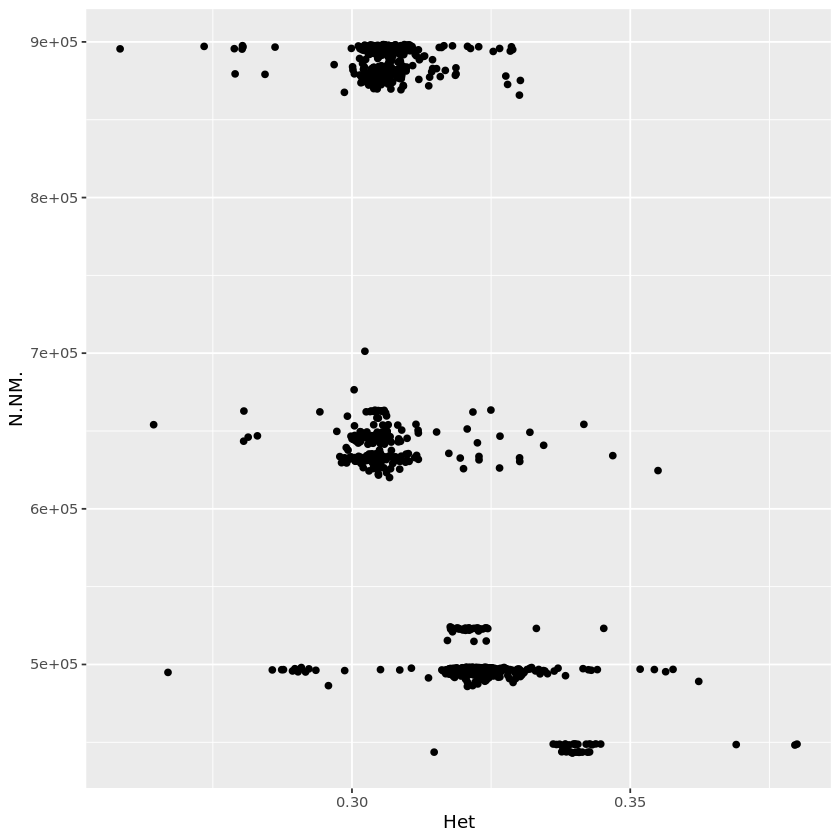

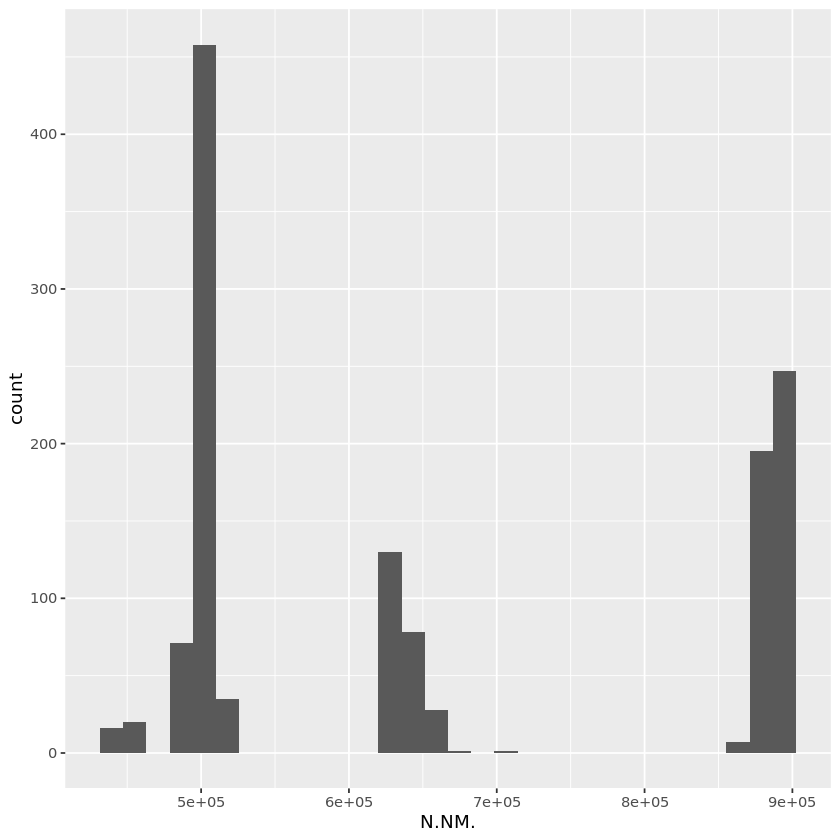

In [10]:
ggplot(d, aes(x = Het, y = N.NM.)) +
    geom_point()
ggplot(d, aes(x = N.NM.)) +
    geom_histogram()

That the data is in three (four) distinct bands may be because of the different chips used, as each chip type can have a different amounbt of missing data

Removing outliers based on non-missing genotypes per individual:

In [32]:
miss_up <- mean(d$N.NM.) + 1.3*sd(d$N.NM.)
miss_down <- mean(d$N.NM.) - 1.3*sd(d$N.NM.)

In [33]:
d_up <- subset(d, N.NM. > miss_up)
d_down <- subset(d, N.NM. < miss_down)

If the data is treated as one large batch it does not seem to make sense filtering for outliers in N.NM. as it will either catch nothing or half the dataset

Splitting data set into 3 distinct subsets:

In [36]:
d_low <- subset(d, N.NM. < 6*(10^5))
d_mid <- subset(subset(d, N.NM. > 6*(10^5)), N.NM. < 8*(10^5))
d_high <- subset(d, N.NM. > 8*(10^5))

In [40]:
length(d_low$N.NM.)
length(d_mid$N.NM.)
length(d_high$N.NM.)

[1] 600

[1] 238

[1] 449

In [48]:
miss_up <- mean(d_low$N.NM.) + 3*sd(d_low$N.NM.)
miss_down <- mean(d_low$N.NM.) - 3*sd(d_low$N.NM.)
d_low_up <- subset(d_low, N.NM. > miss_up)
d_low_down <- subset(d_low, N.NM. < miss_down)

length(d_low_up$N.NM.)
length(d_low_down$N.NM.)

[1] 0

[1] 36

In [49]:
miss_up <- mean(d_mid$N.NM.) + 3*sd(d_mid$N.NM.)
miss_down <- mean(d_mid$N.NM.) - 3*sd(d_mid$N.NM.)
d_mid_up <- subset(d_mid, N.NM. > miss_up)
d_mid_down <- subset(d_mid, N.NM. < miss_down)

length(d_mid_up$N.NM.)
length(d_mid_down$N.NM.)

[1] 2

[1] 0

In [50]:
miss_up <- mean(d_high$N.NM.) + 3*sd(d_high$N.NM.)
miss_down <- mean(d_high$N.NM.) - 3*sd(d_high$N.NM.)
d_high_up <- subset(d_high, N.NM. > miss_up)
d_high_down <- subset(d_high, N.NM. < miss_down)

length(d_high_up$N.NM.)
length(d_high_down$N.NM.)

[1] 0

[1] 0

A total of 38 samples will be removed. In some respects relatively good data is removed however

Removing outlier based on observed heterozygosity rate per individual:

Data is treated as one batch

In [52]:
het_up <- mean(d$Het) + 2*sd(d$Het)
het_down <- mean(d$Het) - 2*sd(d$Het)
d_up <- subset(d, Het > het_up)
d_down <- subset(d, Het < het_down)

length(d_up$Het)
length(d_down$Het)

[1] 44

[1] 21

Creating combined dataframe composed of all outliers and writing to text file:

In [63]:
d_remove <- rbind(d_up, d_down)
d_remove <- rbind(d_remove, d_mid_up)
d_remove <- rbind(d_remove, d_low_down)

In [65]:
write.table(d_remove, file = "outliers.txt", col.names = F, row.names = F)

As duplicate IDs were present in outliers.txt, thus 73 samples were removed, reducing the total amount of people from 1287 to 1214

#### Identification of duplicated or related individuals

The data is pruned for SNPs that are too correlated, the threshold is set to 0.3, thus removing with an r^2 value greater than 0.3. This threshold is sligthly more lax than the typical 0.2, but it has been chosen based on the fact that the data is obtained through different chipssets, where one has a significantly higher amount of missing data

In [3]:
ibd <- read.table("eye_color-QC.genome", header = T)

Here all individuals that are closely related can be identified

In [5]:
ibd

FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
<int>,<int>,<int>,<int>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1173,1173,4814,4814,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1269,1269,1275,1275,UN,NA,0.0021,0.9673,0.0307,0.5143,-1,0.871213,1,989.2500
1424,1424,6035,6035,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1775,1775,2083,2083,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
2651,2651,912,912,UN,NA,0.0020,0.9737,0.0243,0.5111,-1,0.870374,1,1235.3333
3998,3998,6191,6191,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4460,4460,5895,5895,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4547,4547,4632,4632,UN,NA,0.5424,0.4576,0.0000,0.2288,-1,0.803272,1,3.9652
4583,4583,4584,4584,UN,NA,0.2343,0.5394,0.2262,0.4959,-1,0.878240,1,11.2222


In [8]:
members <- ibd$FID1
members <- unique(members)
write.table(cbind(members, members), file = "wrong_ibd.txt", col.names = F, row.names = F)

In [9]:
length(members)

[1] 12

### SNP QC

SNPs with an excessive missing data rate

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1766 rows containing non-finite values (stat_bin).”


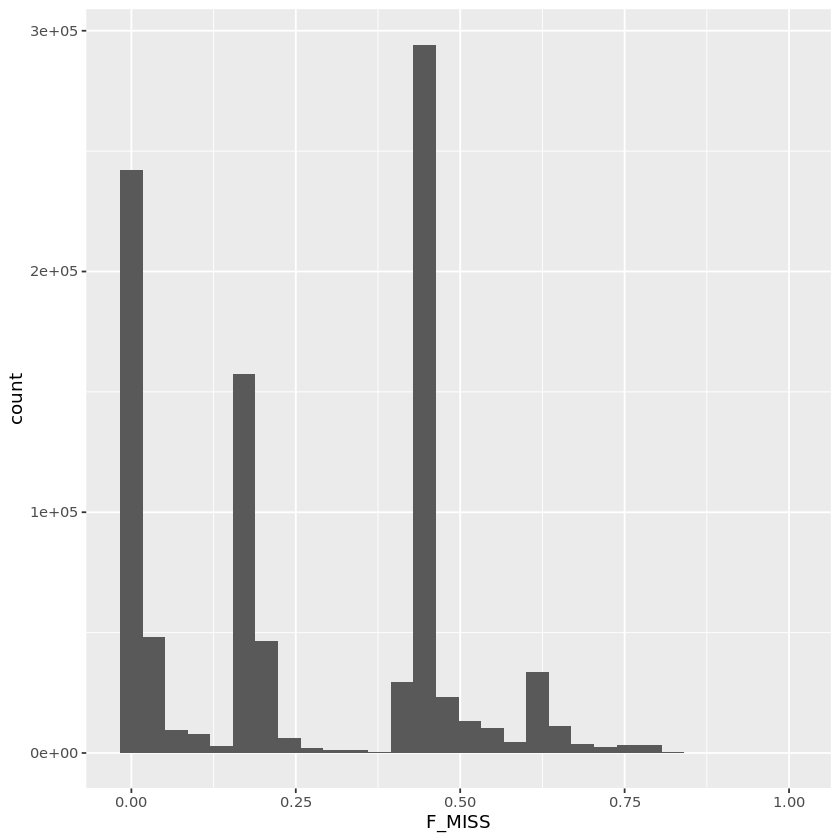

In [13]:
g_miss <- read.table("GWA-eye_color-QC.lmiss", header = T)
ggplot(g_miss, aes(x = F_MISS)) +
    geom_histogram()

7) test for association between missingness and case/control status not relevant as this is not a case/control setup

After removing SNPs based on deviation from HWE and minor allele frequency 843578 of 960613 SNP are left

## PCA

In [4]:
eye_color <- read.table("eye_color.txt", header = T)
length(eye_color$IID)

unique(eye_color$eye_color)

[1] 1287

[1] "brown"             "hazel/brown-green" "blue"             
 [4] "blue-green"        "green"             "blue-grey"        
 [7] "dark_brown"        "amber-brown"       "dark_blue"        
[10] "green-gray"        "blue-green-gold"   "blue-green-grey"

In [5]:
eye_color_alt <- read.table("eye_color.txt", header = T)
eye_color_alt$eye_color[eye_color_alt$eye_color == "blue"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "blue-green"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "green"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "blue-grey"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "dark_blue"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "green-gray"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "blue-green-gold"] <- "non-brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "blue-green-grey"] <- "non-brown"

eye_color_alt$eye_color[eye_color_alt$eye_color == "brown"] <- "brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "hazel/brown-green"] <- "brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "dark_brown"] <- "brown"
eye_color_alt$eye_color[eye_color_alt$eye_color == "amber-brown"] <- "brown"

In [6]:
unique(eye_color_alt$eye_color)
length(subset(eye_color_alt, eye_color_alt$eye_color == "brown")$IID)
length(subset(eye_color_alt, eye_color_alt$eye_color == "non-brown")$IID)

[1] "brown"     "non-brown"

[1] 664

[1] 623

In [1]:
eigenvector <- read.table("GWA-eye_color-QC.eigenvec", header = F)
length(eigenvector$V1)

[1] 1202

In [3]:
head(eigenvector)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1010,1010,0.000564426,-0.00583765,-0.02672580,0.01013600,0.01426510,0.01612080,0.00159321,0.00448325,⋯,-0.005858920,-0.001710080,-0.00278889,-0.016545700,-0.00534773,-0.004618680,-0.01090500,-0.002427070,-0.002296710,-0.010764500
2,1013,1013,0.011323000,-0.00465603,0.01395450,-0.00838522,-0.00862420,0.00229416,0.00655118,0.00523841,⋯,0.000577799,-0.000282797,-0.00124970,-0.012175400,0.00346400,0.004304480,-0.00462808,0.005360430,-0.005287650,0.007912350
3,1020,1020,0.009449360,-0.00824110,0.01454200,-0.01394130,-0.00616703,0.00164963,0.00454347,-0.00098295,⋯,-0.000496464,-0.003434010,0.00407597,-0.000521661,-0.00678310,-0.003797410,0.00102047,-0.002548140,0.005058490,0.011291900
4,1022,1022,0.010424300,-0.00490910,0.01242460,-0.01093320,-0.00357728,0.00801042,0.00147052,-0.01052950,⋯,-0.008746960,-0.006295980,0.00289932,-0.002409330,-0.00217418,0.003779650,0.00292181,0.002610740,0.003847380,0.000212071
5,1024,1024,0.006141010,-0.00281621,0.00566168,-0.00313953,0.00463288,-0.00753255,-0.00359800,-0.00566710,⋯,0.002205110,0.009148450,0.00026096,0.009988880,-0.00721685,0.000285418,-0.00392060,-0.004156840,0.000948279,-0.002779770
6,1026,1026,0.009742560,-0.00588785,0.01407140,-0.00930000,-0.00267791,0.00824829,-0.00480371,-0.00324734,⋯,-0.005146440,0.000201296,0.00530478,0.004955260,0.00441443,-0.001576780,-0.00650788,-0.000901562,0.001809440,0.005789580


In [7]:
eigen_color <- merge(eigenvector, eye_color_alt, by.x = "V1", by.y = "IID", all.x = TRUE, all.y = FALSE)
length(eigen_color$V1)

[1] 1202

In [8]:
head(eigen_color)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V14,V15,V16,V17,V18,V19,V20,V21,V22,eye_color
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,1,0.01015270,-0.00395924,0.0129093,-0.01162680,-0.00783018,-0.00229424,0.00940061,-0.004145210,⋯,0.01553510,0.00298773,0.002928420,-3.97275e-03,0.000552262,-0.00227222,0.00606441,-0.000737238,-0.00552116,non-brown
2,6,6,-0.00325663,0.00518225,-0.1021470,0.04012340,0.04141110,0.03494000,0.00411866,0.000319154,⋯,0.00406677,0.01195610,0.016626700,-7.19293e-05,-0.000723982,0.00243405,0.00550795,-0.016558900,0.00731762,brown
3,8,8,0.00559040,-0.00168191,-0.0235621,0.00382782,0.00766739,0.00290051,-0.00554503,0.005053090,⋯,-0.00483561,0.00423882,-0.003065450,-2.04755e-03,-0.002362690,0.01248450,-0.00116210,0.000474139,-0.00848704,brown
4,10,10,-0.00188047,0.01355990,-0.0834219,0.02829330,-0.01902290,-0.00335972,0.00519990,-0.004121550,⋯,-0.00821782,-0.00342642,-0.000396739,5.19782e-04,0.004042900,-0.00190966,0.00457363,0.003903570,0.01072290,brown
5,11,11,-0.00262361,0.00462705,-0.0929404,0.03617330,0.03748360,0.02438360,0.00482828,-0.001858740,⋯,-0.00793805,0.00257404,0.001082930,3.43202e-03,-0.009472030,0.00235281,0.00062374,0.000224129,-0.01003300,brown
6,13,13,0.00701909,-0.00369964,-0.0217871,0.01026140,0.00849890,0.00661815,0.00250152,-0.003163040,⋯,-0.00801066,0.00305030,-0.005924510,2.54422e-03,-0.002489350,-0.01034920,0.00396387,-0.002791630,0.00028307,brown


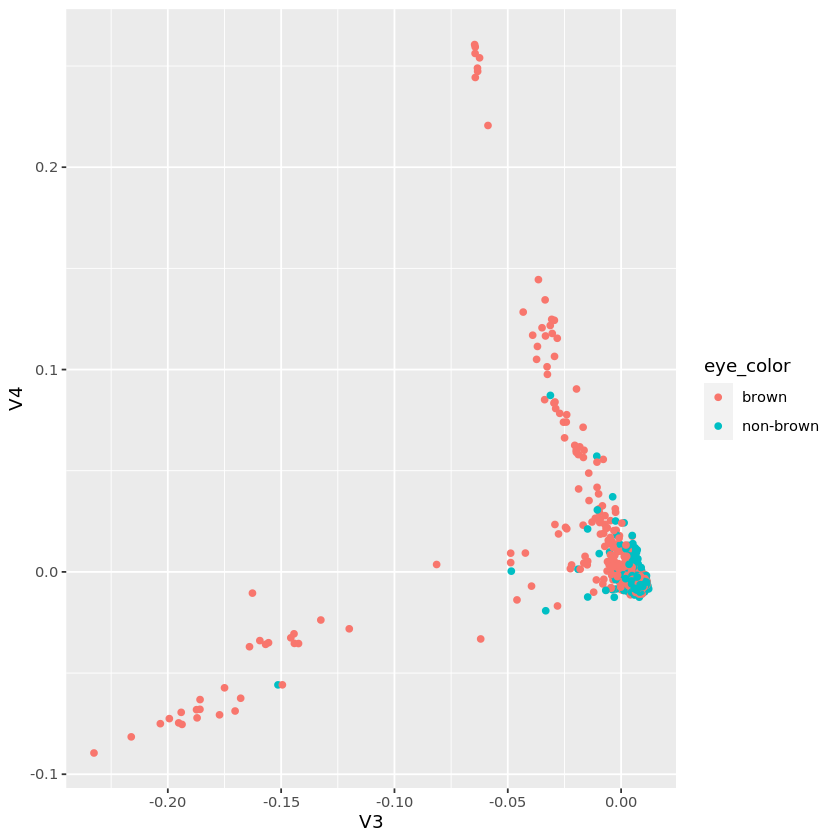

In [9]:
ggplot(eigen_color, aes(x = V3, y = V4, color = eye_color)) +
    geom_point()

In [10]:
eigenval <- read.table("GWA-eye_color-QC.eigenval")

varprop <- eigenval/sum(eigenval)

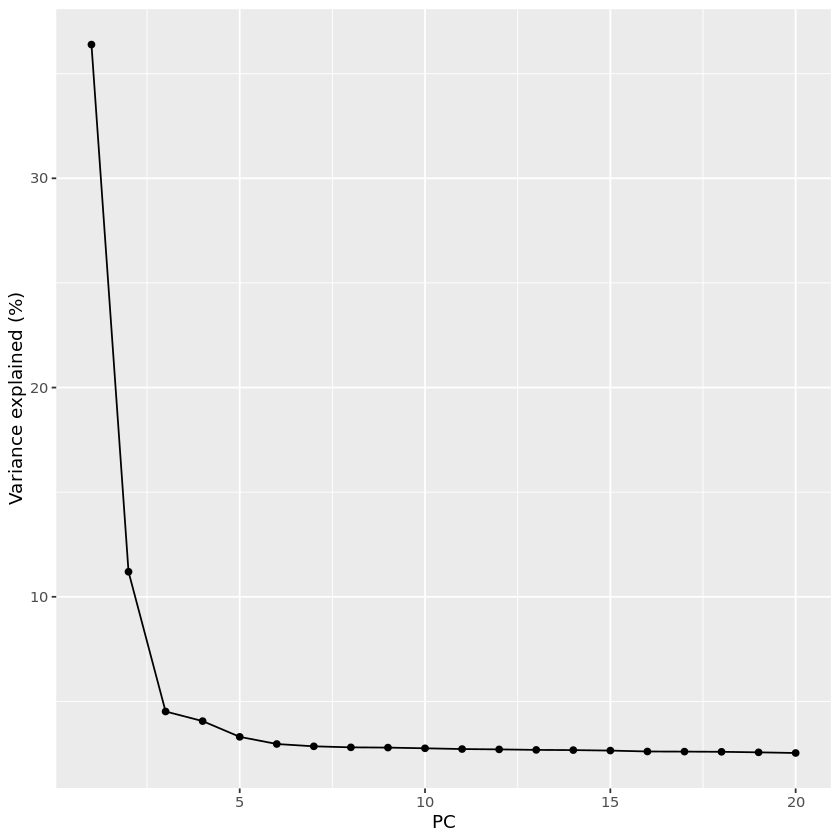

In [11]:
ggplot(varprop, aes(x = seq(1, length(V1)), y = V1*100)) +
    geom_line() +
    geom_point() +
    xlab("PC") +
    ylab("Variance explained (%)")

In [97]:
eye_color_alt$eye_color[eye_color_alt$eye_color == "brown"] <- 1
eye_color_alt$eye_color[eye_color_alt$eye_color == "non-brown"] <- 2
eye_color_alt <- transform(eye_color_alt, eye_color = as.integer(eye_color))

In [98]:
head(eye_color_alt)

,IID,eye_color
,<int>,<int>
1,1010,1
2,1013,1
3,1020,2
4,1022,2
5,1024,2
6,1026,1


In [99]:
write.table(eye_color_alt[, c("IID", "IID", "eye_color")], file = "eye_color_alt.txt", col.names = T, row.names = F)

Second column becomes "IID.1", which is then manually renamed to "FID"

In [1]:
library("qqman")



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





In [1]:
fisher <- read.table("GWA-pheno.assoc.fisher", head = T)

In [8]:
fisheradj <- read.table("GWA-pheno.assoc.fisher.adjusted", head = T)

In [11]:
subset(fisher, fisher$P == min(fisher$P))
subset(fisheradj, fisheradj$BONF == min(fisheradj$BONF))

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
679995,15,rs1667394,28530182,C,0.04444,0.3913,T,5.963e-95,0.07235


,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15,rs1667394,5.963e-95,3.018e-57,5.02e-89,5.02e-89,Inf,Inf,5.02e-89,7.138e-88


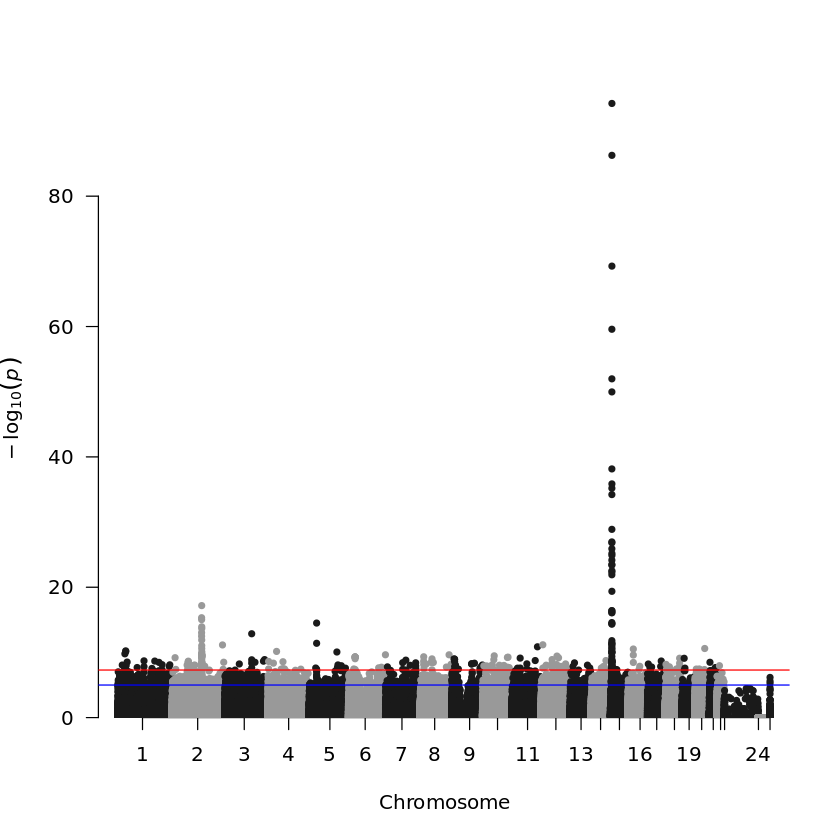

In [7]:
manhattan(fisher)

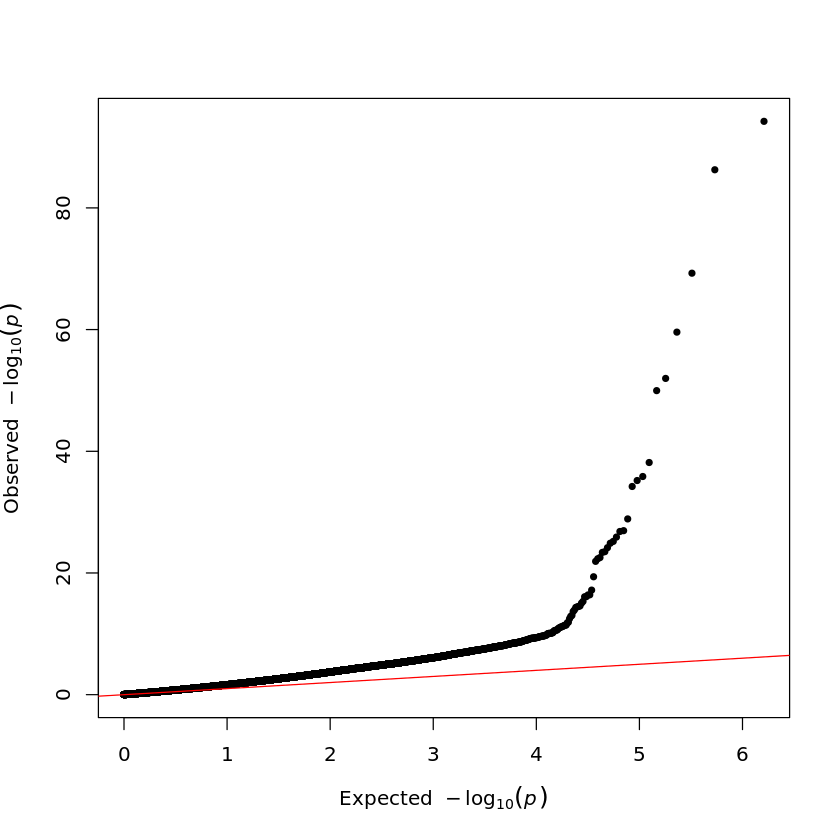

In [12]:
qq(fisher$P)

In [2]:
inflationfac <- median(qchisq(fisher$P, df=1, lower.tail = F))/0.5
inflationfac

[1] 1.523381

In [3]:
fisher$adjusted <- pchisq((qchisq(fisher$P, df=1, lower.tail = F)/inflationfac), df=1, lower.tail = F)

In [15]:
subset(fisher, fisher$adjusted == min(fisher$adjusted))

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,adjusted
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
679995,15,rs1667394,28530182,C,0.04444,0.3913,T,5.963e-95,0.07235,5.658033e-63


In [4]:
inflationfac_adj <- median(qchisq(fisher$adjusted, df=1, lower.tail = F))/0.5
inflationfac_adj

[1] 1

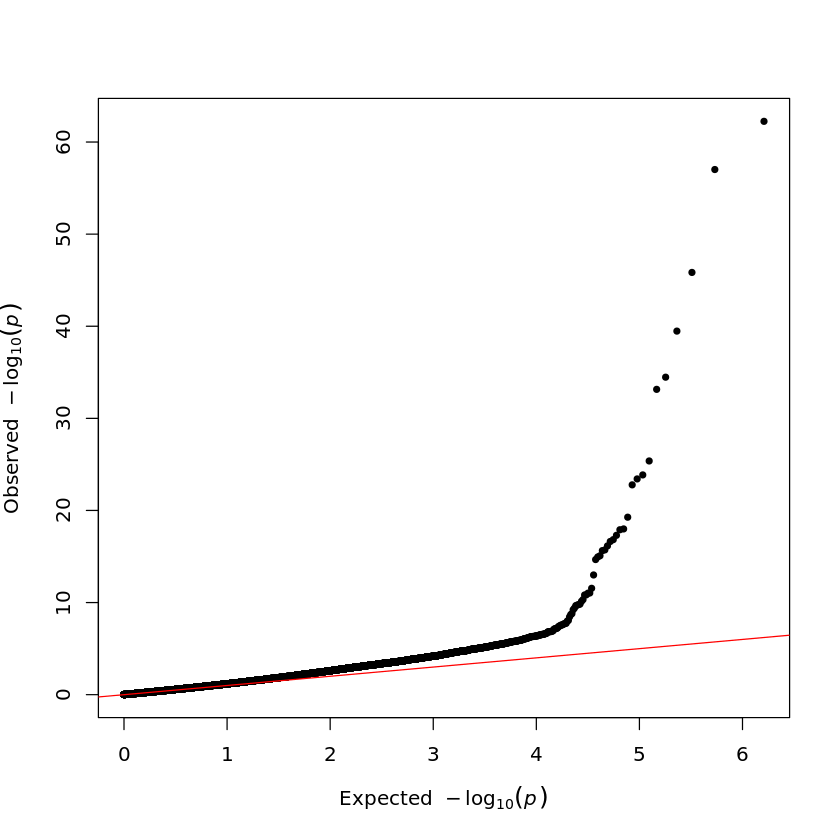

In [16]:
qq(fisher$adjusted)

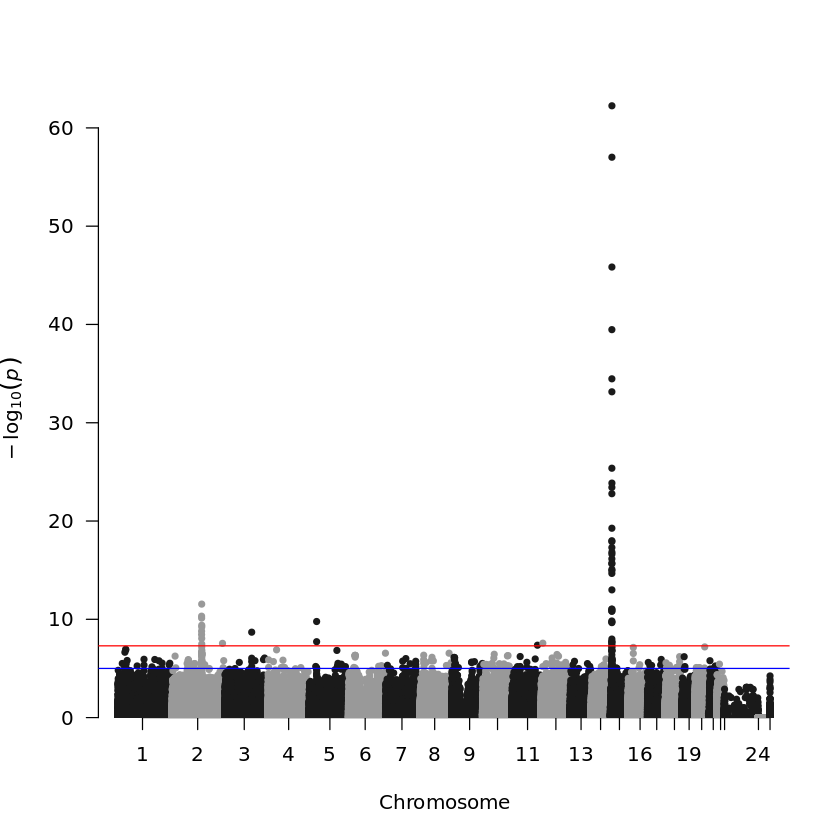

In [17]:
manhattan(fisher, p = "adjusted")

In [123]:
snpsofint <- subset(fisher, fisher$CHR == 15)
snpsofint <- snpsofint[order(snpsofint$adjusted), ]
snpsofint <- snpsofint[1:30, ]
snpsofint <- snpsofint$SNP

In [125]:
snpsofint

[1] "rs1667394"  "rs916977"   "rs8039195"  "rs4778241"  "rs3935591" 
 [6] "rs11636232" "rs4778138"  "rs16950987" "rs7495174"  "rs7174027" 
[11] "rs7183877"  "rs4778232"  "rs12593929" "rs7170869"  "rs2240203" 
[16] "rs16950993" "rs1597196"  "rs6497253"  "rs8024968"  "rs8028689" 
[21] "rs1375164"  "rs16950821" "rs6497287"  "rs749846"   "rs7177686" 
[26] "rs7179994"  "rs7170451"  "rs7170989"  "rs728405"   "rs3794604"

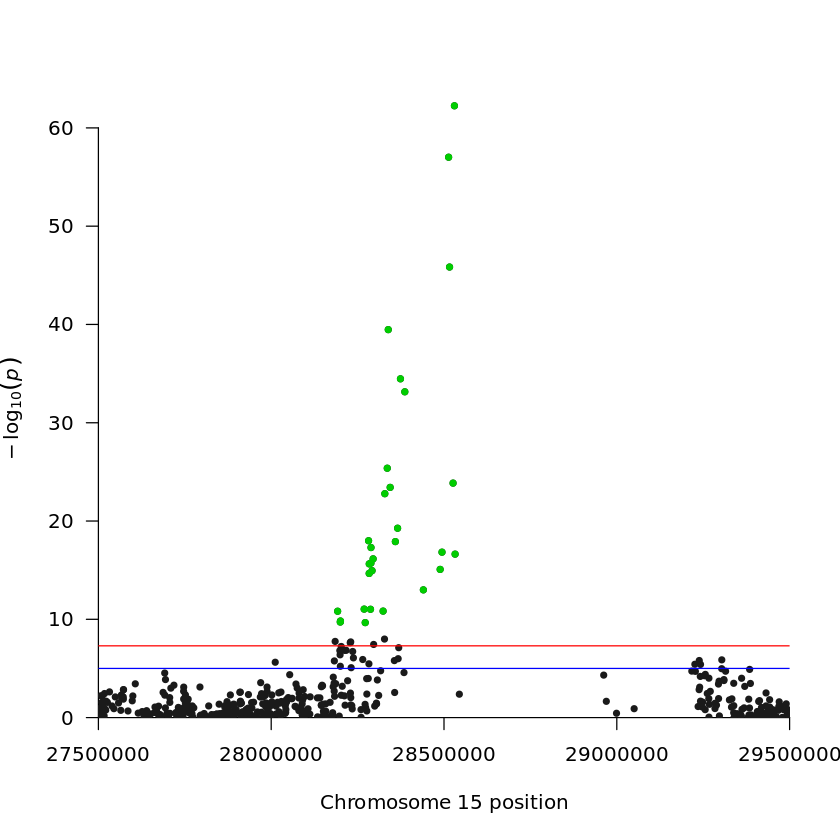

In [124]:
manhattan(subset(fisher, CHR == 15), p = "adjusted", highlight = snpsofint, xlim = c(2.75*10^7, 2.95*10^7))

### Adjusting for PCs

In [7]:
pcadj <- read.table("plink.assoc.logistic", header = T)
pcadj <- subset(pcadj, pcadj$TEST == "ADD")
head(pcadj)

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,rs3094315,752566,G,ADD,549,1.0540,0.2975,0.7661
3,1,rs3131972,752721,A,ADD,1163,1.1240,0.9918,0.3213
5,1,rs12124819,776546,G,ADD,953,0.9627,-0.3382,0.7352
7,1,rs11240777,798959,A,ADD,1168,0.9457,-0.5255,0.5992
9,1,rs6681049,800007,T,ADD,631,1.1240,0.2046,0.8379
11,1,rs4970383,838555,A,ADD,1149,1.1490,1.3280,0.1841


In [7]:
na_pcadj <- subset(pcadj, is.na(pcadj$P) == TRUE)

In [8]:
num_pcadj <- subset(pcadj, is.na(pcadj$P) == FALSE)
head(num_pcadj)

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,rs3094315,752566,G,ADD,549,1.0540,0.2975,0.7661
3,1,rs3131972,752721,A,ADD,1163,1.1240,0.9918,0.3213
5,1,rs12124819,776546,G,ADD,953,0.9627,-0.3382,0.7352
7,1,rs11240777,798959,A,ADD,1168,0.9457,-0.5255,0.5992
9,1,rs6681049,800007,T,ADD,631,1.1240,0.2046,0.8379
11,1,rs4970383,838555,A,ADD,1149,1.1490,1.3280,0.1841


In [9]:
subset(num_pcadj, num_pcadj$P == min(num_pcadj$P))

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1359989,15,rs1667394,28530182,C,ADD,1092,0.06514,-15.41,1.301e-53


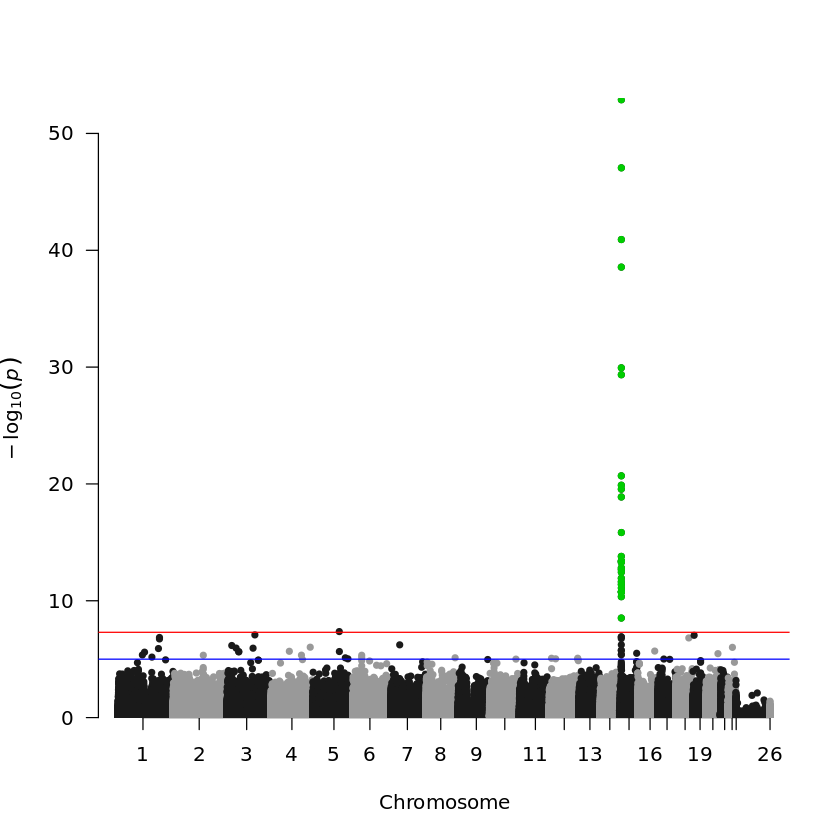

In [127]:
manhattan(num_pcadj, highlight = altsnpsofint)

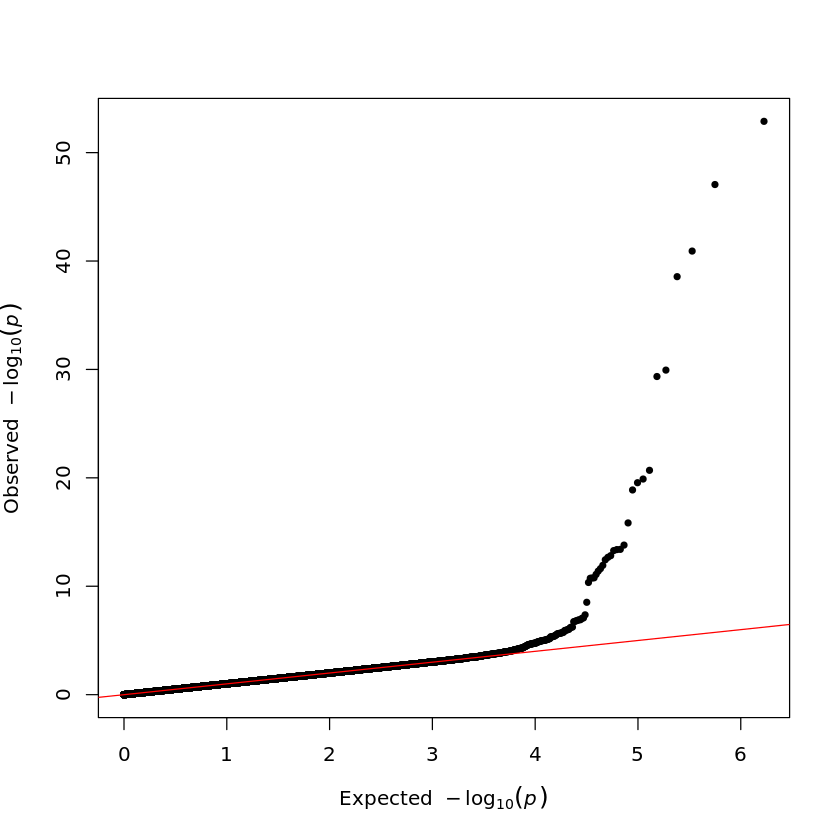

In [47]:
qq(num_pcadj$P)

In [10]:
altsnpsofint <- subset(num_pcadj, num_pcadj$CHR == 15)
altsnpsofint <- altsnpsofint[order(altsnpsofint$P), ]
altsnpsofint <- altsnpsofint[1:27, ]
head(altsnpsofint)

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1359989,15,rs1667394,28530182,C,ADD,1092,0.06514,-15.41,1.301e-53
1359983,15,rs916977,28513364,T,ADD,1057,0.07371,-14.52,8.788e-48
1359985,15,rs8039195,28516084,C,ADD,980,0.07777,-13.52,1.206e-41
1359955,15,rs4778241,28338713,A,ADD,1202,0.16330,-13.11,2.764e-39
1359975,15,rs11636232,28386626,T,ADD,1176,3.42100,11.51,1.153e-30
1359971,15,rs3935591,28374012,T,ADD,628,0.06605,-11.39,4.498e-30


In [111]:
altsnpsofint <- altsnpsofint$SNP

In [93]:
altsnpsofint

[1] "rs1667394"  "rs916977"   "rs8039195"  "rs4778241"  "rs11636232"
 [6] "rs3935591"  "rs4778138"  "rs7495174"  "rs7183877"  "rs7174027" 
[11] "rs16950987" "rs4778232"  "rs8024968"  "rs1597196"  "rs16950821"
[16] "rs12593929" "rs7170869"  "rs6497287"  "rs6497253"  "rs3794604" 
[21] "rs1375164"  "rs8028689"  "rs16950993" "rs2240203"  "rs749846"  
[26] "rs7179994"  "rs7177686"  "rs728405"   "rs7170989"  "rs7170451"

In [126]:
altsnpsofint[!(altsnpsofint %in% snpsofint)]

character(0)

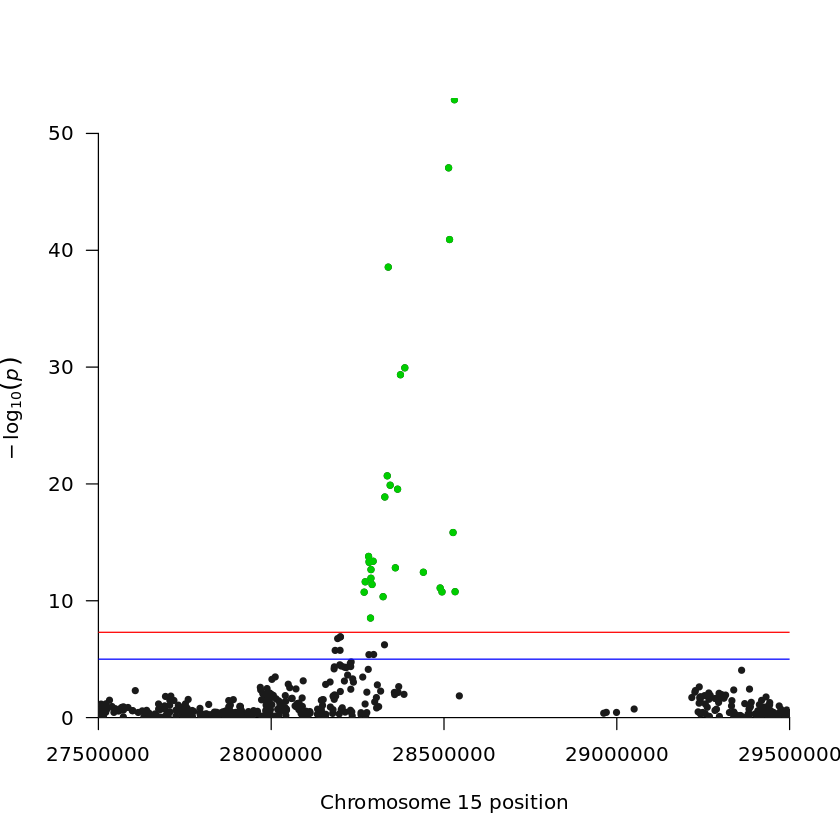

In [112]:
manhattan(subset(num_pcadj, CHR == 15), highlight = altsnpsofint, xlim = c(2.75*10^7, 2.95*10^7))

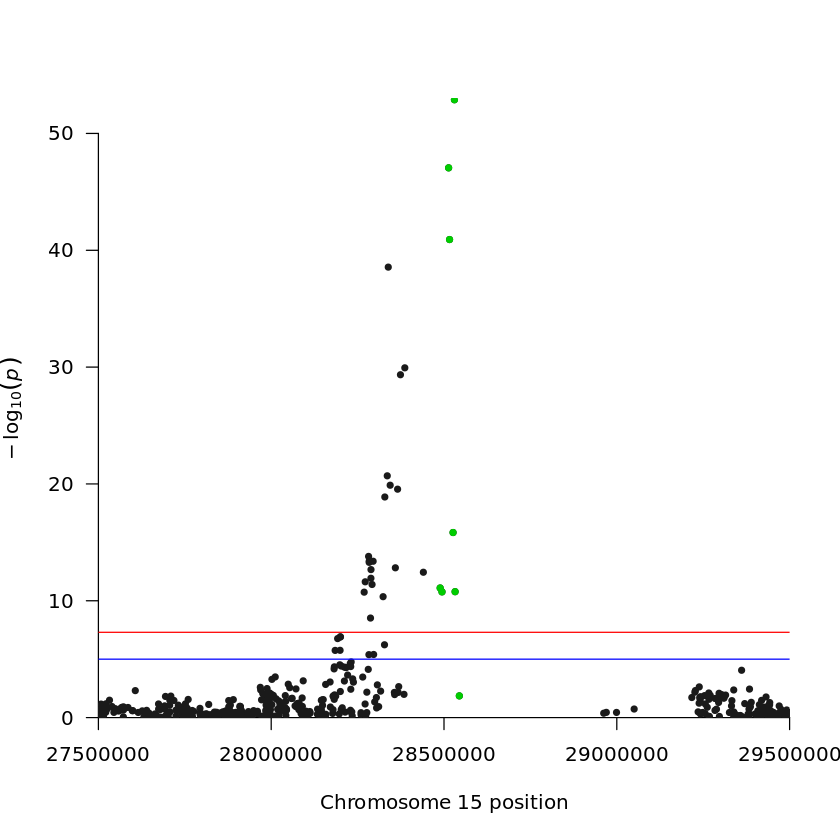

In [11]:
manhattan(subset(num_pcadj, CHR == 15), highlight = usnps, xlim = c(2.75*10^7, 2.95*10^7))

In [128]:
inflationfac_aftercorrec <- median(qchisq(num_pcadj$P, df=1, lower.tail = F))/0.5
inflationfac_aftercorrec

[1] 0.9196747

### SNPs of interest

In [15]:
snp100kb <- read.table("snp_100kbwindow.raw", header = T)
head(snp100kb)
(length(snp100kb)-6)/2

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs8028689_C,rs8028689_HET,rs2240203_C,rs2240203_HET,⋯,rs8039195_C,rs8039195_HET,rs16950987_A,rs16950987_HET,rs1667394_C,rs1667394_HET,rs16950993_G,rs16950993_HET,rs1667400_A,rs1667400_HET
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,1,0,0,NA,NA,⋯,0,0,0,0,1,1,NA,NA,NA,NA
2,1013,1013,0,0,0,1,0,0,0,0,⋯,1,1,0,0,1,1,0,0,0,0
3,1020,1020,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1022,1022,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1024,1024,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1026,1026,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 8

In [27]:
unique(snp100kb$rs1667394_C)

[1]  1  0  2 NA

In [5]:
usnps <- list("rs8028689", "rs2240203", "rs916977", "rs8039195", "rs16950987", "rs1667394", "rs16950993", "rs1667400")

In [16]:
snp200kb <- read.table("snp_200kbwindow.raw", header = T)
head(snp200kb)
(length(snp200kb)-6)/2

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs6497287_C,rs6497287_HET,rs8028689_C,rs8028689_HET,⋯,rs8039195_C,rs8039195_HET,rs16950987_A,rs16950987_HET,rs1667394_C,rs1667394_HET,rs16950993_G,rs16950993_HET,rs1667400_A,rs1667400_HET
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,1,NA,NA,0,0,⋯,0,0,0,0,1,1,NA,NA,NA,NA
2,1013,1013,0,0,0,1,1,1,0,0,⋯,1,1,0,0,1,1,0,0,0,0
3,1020,1020,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1022,1022,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1024,1024,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1026,1026,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 9

In [17]:
snp300kb <- read.table("snp_300kbwindow.raw", header = T)
head(snp300kb)
(length(snp300kb)-6)/2

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs6497282_C,rs6497282_HET,rs11636232_T,rs11636232_HET,⋯,rs8039195_C,rs8039195_HET,rs16950987_A,rs16950987_HET,rs1667394_C,rs1667394_HET,rs16950993_G,rs16950993_HET,rs1667400_A,rs1667400_HET
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,1,NA,NA,0,0,⋯,0,0,0,0,1,1,NA,NA,NA,NA
2,1013,1013,0,0,0,1,0,0,0,0,⋯,1,1,0,0,1,1,0,0,0,0
3,1020,1020,0,0,0,2,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
4,1022,1022,0,0,0,2,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
5,1024,1024,0,0,0,2,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
6,1026,1026,0,0,0,1,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11

In [18]:
snp400kb <- read.table("snp_400kbwindow.raw", header = T)
head(snp400kb)
(length(snp400kb)-6)/2

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs4778138_G,rs4778138_HET,rs4778241_A,rs4778241_HET,⋯,rs8039195_C,rs8039195_HET,rs16950987_A,rs16950987_HET,rs1667394_C,rs1667394_HET,rs16950993_G,rs16950993_HET,rs1667400_A,rs1667400_HET
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,1,0,0,0,0,⋯,0,0,0,0,1,1,NA,NA,NA,NA
2,1013,1013,0,0,0,1,0,0,1,1,⋯,1,1,0,0,1,1,0,0,0,0
3,1020,1020,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1022,1022,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1024,1024,0,0,0,2,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
6,1026,1026,0,0,0,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0


[1] 21

In [19]:
snp500kb <- read.table("snp_500kbwindow.raw", header = T)
head(snp500kb)
(length(snp500kb)-6)/2

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs4238497_A,rs4238497_HET,rs4778232_T,rs4778232_HET,⋯,rs8039195_C,rs8039195_HET,rs16950987_A,rs16950987_HET,rs1667394_C,rs1667394_HET,rs16950993_G,rs16950993_HET,rs1667400_A,rs1667400_HET
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,1,0,0,1,1,⋯,0,0,0,0,1,1,NA,NA,NA,NA
2,1013,1013,0,0,0,1,0,0,0,0,⋯,1,1,0,0,1,1,0,0,0,0
3,1020,1020,0,0,0,2,NA,NA,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1022,1022,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1024,1024,0,0,0,2,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1026,1026,0,0,0,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0


[1] 41

In [20]:
summary(glm(PHENOTYPE ~ rs1667394_C, data = snp100kb))


Call:
glm(formula = PHENOTYPE ~ rs1667394_C, data = snp100kb)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6980  -0.2350   0.2279   0.3020   1.2279  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.69801    0.01536  110.54   <2e-16 ***
rs1667394_C -0.46298    0.02039  -22.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1699968)

    Null deviance: 272.97  on 1091  degrees of freedom
Residual deviance: 185.30  on 1090  degrees of freedom
  (110 observations deleted due to missingness)
AIC: 1168

Number of Fisher Scoring iterations: 2


In [7]:
snp400kb <- read.table("snp_400kbwindow.raw", header = T)

eye_color <- read.table("eye_color.txt", header = T)

In [8]:
snp_exactpheno <- merge(snp400kb, eye_color, by.x = "IID", by.y = "IID", all.x = TRUE, all.y = FALSE)

In [14]:
head(snp_exactpheno)

,IID,FID,PAT,MAT,SEX,PHENOTYPE,rs4778138_G,rs4778138_HET,rs4778241_A,rs4778241_HET,⋯,rs8039195_HET,rs16950987_A,rs16950987_HET,rs1667394_C,rs1667394_HET,rs16950993_G,rs16950993_HET,rs1667400_A,rs1667400_HET,eye_color
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1,1,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,blue-green
2,6,6,0,0,0,1,1,1,1,1,⋯,1,1,1,1,1,1,1,0,0,brown
3,8,8,0,0,0,1,0,0,1,1,⋯,1,0,0,1,1,0,0,0,0,brown
4,10,10,0,0,0,1,2,0,2,0,⋯,0,2,0,2,0,2,0,0,0,brown
5,11,11,0,0,0,1,0,0,1,1,⋯,1,0,0,1,1,0,0,0,0,brown
6,13,13,0,0,0,1,0,0,1,1,⋯,1,0,0,1,1,0,0,0,0,brown


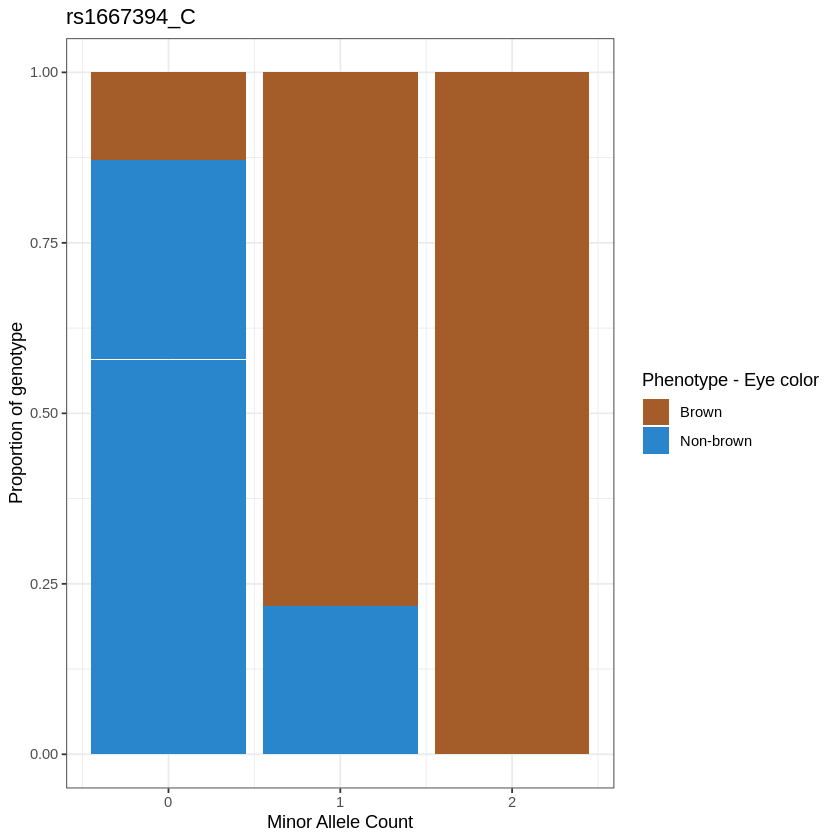

In [19]:
ggplot(na.omit(snp_exactpheno), aes(x = rs1667394_C, y = PHENOTYPE, fill = as.character(PHENOTYPE))) +
  geom_bar(position = "fill", stat = "identity") +
    xlab("Minor Allele Count") +
    ylab("Proportion of genotype") +
    ggtitle("rs1667394_C") +
    scale_fill_manual(labels = c("Brown", "Non-brown"), values = c("#a45d29", "#2986cc")) +
    guides(fill = guide_legend(title = "Phenotype - Eye color")) +
    theme_bw()

## Epistasis

plink --bfile GWA-pheno --allow-no-sex --assoc perm set-test --set rs1667394.set --fast-epistasis set-by-all --out epistasis

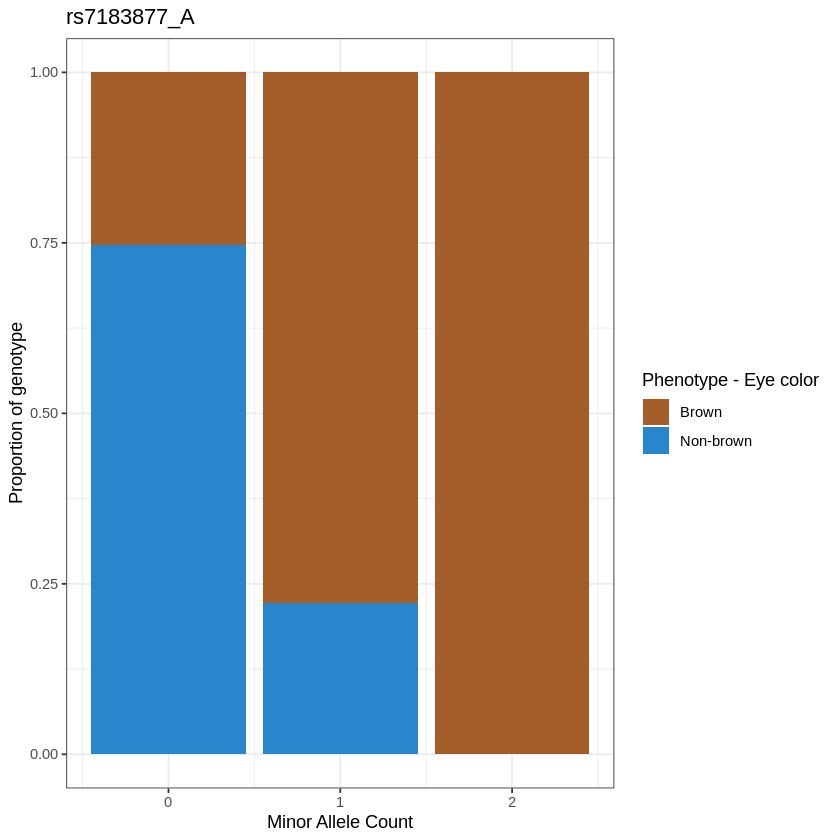

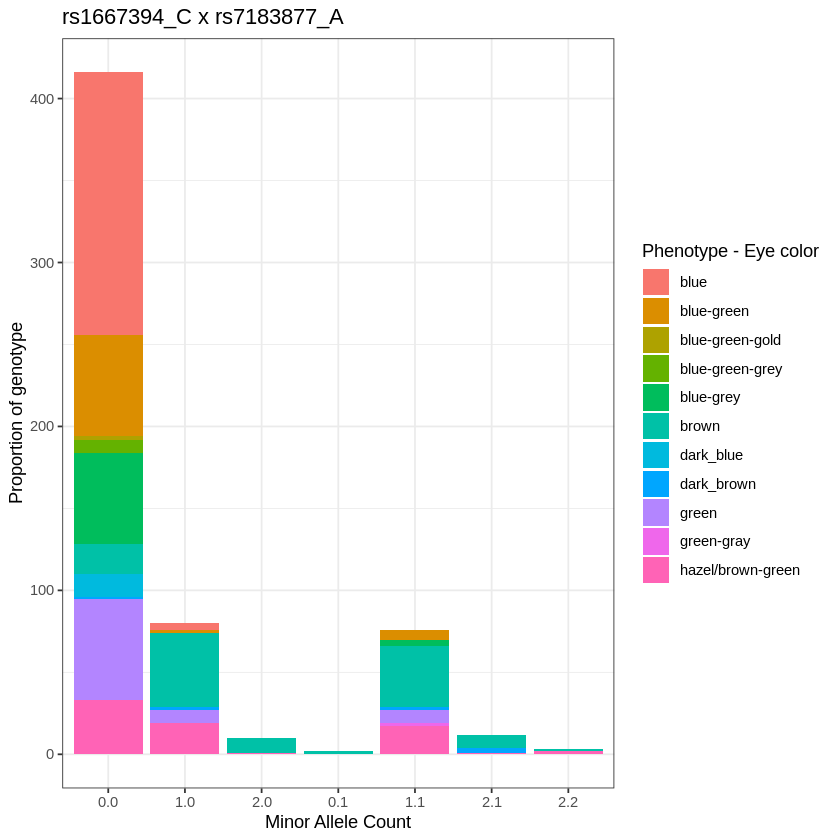

In [20]:
ggplot(na.omit(snp_exactpheno), aes(x = rs7183877_A, y = PHENOTYPE, fill = as.character(PHENOTYPE))) +
  geom_bar(position = "fill", stat = "identity") +
    xlab("Minor Allele Count") +
    ylab("Proportion of genotype") +
    ggtitle("rs7183877_A") +
    scale_fill_manual(labels = c("Brown", "Non-brown"), values = c("#a45d29", "#2986cc")) +
    guides(fill = guide_legend(title = "Phenotype - Eye color")) +
    theme_bw()
ggplot(na.omit(snp_exactpheno), aes(x = interaction(rs1667394_C, rs7183877_A), y = PHENOTYPE, fill = as.character(eye_color))) +
  geom_bar(stat = "identity") +
    xlab("Minor Allele Count") +
    ylab("Proportion of genotype") +
    ggtitle("rs1667394_C x rs7183877_A") +
    #scale_fill_manual(labels = c("Brown", "Non-brown"), values = c("#a45d29", "#2986cc")) +
    guides(fill = guide_legend(title = "Phenotype - Eye color")) +
    theme_bw()